# Ajuste de las curvas obtenidas en el transitorio del circuito RCL Sub amortiguado

En este tutorial analizo los datos adquiridos de un circuito **RLC transitorio sub amortiguado**.

El circuito tiene las siguientes características:

```
 _____ -V0 (PULSE)+ _____ R _____ L _____ C ____   
|                     |               |         |  
GND                  Vin              VC        GND
```

Parámetros:
- R = 1 $k \Omega$
- L = 10 $m H$
- C = 1 $n F$

- Tiempo característico $\tau = 2L/R \approx 20$ usec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Periodo $T= 20 \tau \approx 400$ usec
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa).
- En $V_C$ se mide la tensión en el capacitor respecto de GND (masa).

Empezamos importando las librerías necesarias:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos:

Columnas: Index(['time', 'Vin', 'VC', 'VL'], dtype='object')


<Axes: xlabel='time'>

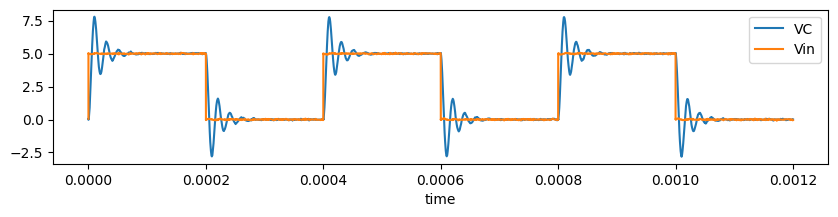

In [56]:
df = pd.read_csv("datos/data_RLC_sub.csv")
print("Columnas:", df.columns)

df.plot( x='time', y=['VC','Vin'], figsize=(10,2) )

#### Tratamiento de las unidades

Queremos ajustar el decaimiento subamortiguado que se oberva en la curva azul $V_C$.
El primer problema con el que nos encontramos es que los valores en el eje x estan en el orden de $\sim 10^{-5}$ y los del eje y en el orden de $\sim 10^1$. Esta disparidad puede incrementar los errores numericos y hacer que el ajuste no salga bien, por lo tanto vamos a cambiar la unidad del eje temporal de manera de tener valores del mismo orden en ambos ejes. 

Propongo dividir por un facto $U=10^{-5}$,

<Axes: xlabel='time'>

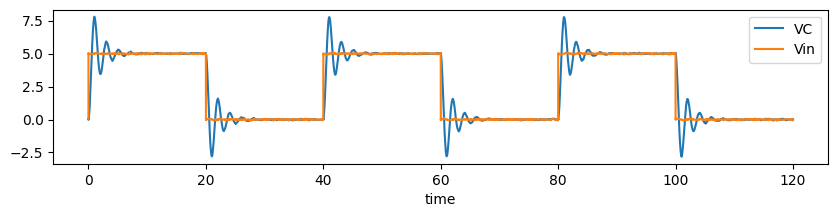

In [ ]:
U= 1e-5

df["time"]/=U

df.plot( x='time', y=['VC','Vin'], figsize=(10,2) )

#### Aislamiento de un pulso para el ajuste

Filtramos los datos para quedarnos solo con uno de transitorios. Nos quedamos con el que esta entre los tiempos 40 y 60.

<Axes: xlabel='time'>

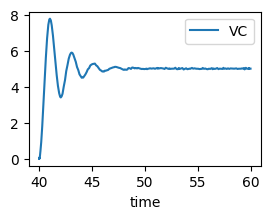

In [60]:
df_alto = df[ (df["time"]<60) & (df["time"]>40) ]

df_alto.plot(x='time', y='VC', figsize=(3,2))

#### Translación del eje temporal

El eje temporal esta trasladado, **llevamos el origen a cero** restando el primer punto, tambien pasamos nuestros datos a arrays de numpy para trabajar más cómodos el ajuste:

In [61]:
t0 = df_alto["time"].iloc[0] # primer valor del array

t = df_alto["time"].to_numpy()-t0

VC = df_alto["VC"].to_numpy()

#### Propuesta de modelo para el ajuste

Definimos una **ecuación** para hacer el ajuste de la tensión que cae en los bornes del capacitor:

$$
V_C = V_0 \big( 1 - e^{-\gamma t} ( cos(\omega t) + \frac{\gamma}{\omega} sin(\omega t)   ) \big)
$$

In [28]:
def modelo_VC(u, V0, g, w):                         
    vc= V0*( 1- np.exp(-g*u)*( np.cos(w*u)+ (g/w)*np.sin(w*u) ) )    # Ec para la tensión VC caso sub amort
    return vc

#### Respecto a las unidades de los parámetros del modelo

Los parámetros del ajuste son la amplitud de la tensión de entrada $V_0$ (V0), el amortiguamiento $\gamma$ (g) y la frecuencia angular $\omega$ (w).

La idea es usar la teoria para estimar los valores iniciales de los parámeros para pasarselos al algoritmo como **semillas**. El parámetro lo voy a setear en **V0=5 V**. Para los parámetros **g** y **w** uso las expresiones matemáticas, sabemos,

$$
\gamma = \sqrt { \frac{R}{2 L}} \quad [1/sec]
$$

$$
\omega^2= \frac{1}{L C} \quad [rad/sec]
$$

Como estamos trabajando con la unidad temporal U en el eje x, hay que transformar esos valores,

$$
\gamma = \frac{R}{2 L}U \quad [1/U sec]
$$

$$
\omega= \sqrt { \frac{1}{L C} U^2} \quad [rad/Usec]
$$

#### Estimación de las semillas

Ahora si, calculamos las semillas


In [62]:
# los valores de los componente de mi circuito
R= 1000 + 50 +100
L= 10e-3
C= 1e-9

# calculo de los parámetros usando la teoria
g = (R/(2.0*L))*U
w02 = (1.0/(L*C))*(U**2)
w = np.sqrt(w02 - g**2 )

print (f"Amortiguamiento teórico: {g:.3f} 1/usec")
print (f"Freq angular teórica: {w:.2f} rad/usec")

Amortiguamiento teórico: 0.575 1/usec
Freq angular teórica: 3.11 rad/usec


#### Realización del ajuste

In [65]:
# seteamos las semillas usando el resultado anterior
V0_ini = 5
g_ini  = 0.575
w_ini  = 3.11

# ajuste
popt, pcov = curve_fit(modelo_VC, t, VC, p0=[ V0_ini, g_ini, w_ini ] )      

# tomo parámetros
V0, g, w = popt

# Errores estandar
SE_V0, SE_g, SE_w = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f}) [V]")
print(f"g  = ({g:.4f} ± {SE_g:.6f}) [1/Usec]")
print(f"w  = ({w:.4f} ± {SE_w:.6f}) [rad/Usec]")

Parámetros obtenidos del ajuste:
V0 = (4.9973 ± 0.0017) [V]
g  = (0.5710 ± 0.001831) [1/Usec]
w  = (3.0798 ± 0.001941) [rad/Usec]


Vemos que los parámetros obtenidos del ajuste coinciden con los valores teóricos calculados.

Hacemos un **plot** con los datos del experimento y el ajuste:

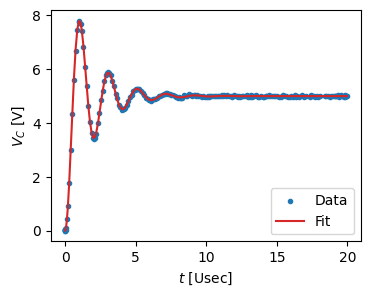

In [66]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                         # datos

ax.plot( t, modelo_VC(t, V0, g, w), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Usec]")
ax.set_ylabel("$V_C$ [V]")

plt.legend(loc=4)
plt.show()